# Download data from NORA3 and save to ncfile

The following codes is a guide to download data from the NWP NORA3 extracted at one location with coordinates (Lat/Lon) for a chosen time period and save it as an nc-file, available at https://thredds.met.no/thredds/catalog/nora3_subset_atmos/atm_hourly/catalog.html. This script use the subset atmosphere files. Some variables:
- wind_speed and wind_direction at height 10 meters above surface
- Air temperature at 2 meters above surface
- surface air pressure. 

choose a datespan (years, months) and save it as a ncfile.

Data available from: 1985.01 to (current month minus 6-7 months time lag), check link for latest date

Model runs 4 times a day, every 6h, the files contains hourly updated data based on these runs



In [28]:
# Importing necessary modules

import xarray as xr
import numpy as np

import netCDF4 as nc
import matplotlib.pylab as plt
import pandas as pd

import pyproj
import datetime as dt
from datetime import date, timedelta

import requests
from __future__ import print_function
from IPython.display import display, HTML

In [29]:
"""
The coordinates in get_coordinates is at the center of the offshore wind sites
"""

def get_coordinates_center_OWS(location_name):
    locations = {
        'Nordavind_A': {
            'latitude': 71.1314956,
            'longitude': 32.048109
        },
        'Nordavind_B': {
            'latitude': 71.7880587,
            'longitude': 27.7221338
        },
        'Nordavind_C': {
            'latitude': 71.7471898,
            'longitude': 19.9808019
        },
        'Nordavind_D': {
            'latitude': 71.473272,
            'longitude': 18.7614613
        },
        'Utsira_nord': {
            'latitude': 59.2740869,
            'longitude': 4.5441279
        },
        'Sørlige_nordsjø_2': {
            'latitude': 59.7894747,
            'longitude': 4.9314619
        }
    }

    if location_name in locations:
        coordinates = locations[location_name]
        return coordinates['latitude'], coordinates['longitude']
    else:
        return None



## Seklima station information retrival with frost api 

[Link to frost webpage](https://frost.met.no/index.html)

1. Create client id for yourself 
    * [Create client id here](https://frost.met.no/auth/requestCredentials.html)
    
This is used to retrive the longitude and latitude

In [30]:
# Insert your own client ID here
client_id = 'insert client ID'

In [31]:
'''
Getting the data for the meta dataframe

Using the frost api for seklima
'''

endpoint = 'https://frost.met.no/sources/v0.jsonld'

# Dictionary with elements to retrieve
parameters = {
    'fields': 'name,id,geometry,masl,validFrom'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data_exp = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [32]:
'''
Transforming the data from a raw json format retrieved by requests 
to a pandas df format

When redefining the query the new columns need to be spesified for the dataframe df
'''

meta_df = pd.DataFrame(columns=['id', 'name', 'lon', 'lat', 'heigh-asl (m)','operating period (from)'])
ignored_values = 0
for i in range(len(data_exp)):
    row = []
    try:
        row.append(data_exp[i]['id'])
        row.append(data_exp[i]['name'])
        row.append(data_exp[i]['geometry']['coordinates'][0])
        row.append(data_exp[i]['geometry']['coordinates'][1])
        row.append(data_exp[i]['masl'])
        row.append(data_exp[i]['validFrom'])
        meta_df.loc[len(meta_df)] = row
    except:
        ignored_values += 1
        continue


print(f'Number of discarded values {ignored_values}')

# Setting the station id as row index2
meta_df = meta_df.set_index('id')

display(meta_df)

Number of discarded values 88


,name,lon,lat,heigh-asl (m)
id,,,,
SN47230,ÅKRA UNGDOMSSKOLE,5.196300,59.255500,18
SN23670,E16 RYFOSS,8.817500,61.137500,406
SN59450,STADLANDET,5.211500,62.146700,75
SN12590,E6 MJØSBRUA,10.672500,60.928000,128
SN26640,E134 DARBU,9.777300,59.702500,155
...,...,...,...,...
SN74780,NAMSVATN II,13.540300,64.960800,460
SN1292500,NAGYKANIZSA,16.970556,46.456111,139
SN1712400,ESKISEHIR HAVALIMANI,30.579700,39.781000,786


- Change station ID to match measurement station to get station coordinates
    * Find station ID at ([stations](https://seklima.met.no/stations/))
 
or 

- Insert site_name to get coordinates from center of OWS

In [33]:

#################


station_id = "SN76956" # insert station ID, ex: 'SN76956' Goliat ,  'SN20926' hjelmsøybanken  ,   SN76926 Sleipner


################

longitude = meta_df.loc[f"{station_id}"]["lon"]
latitude = meta_df.loc[f"{station_id}"]["lat"]

print(f"{station_id}: longitude = {longitude}, latitude = {latitude}")

SN76956: longitude = 22.25, latitude = 71.3112


In [ ]:
# insert the site name you want the data extracted from

################

site_name = 'Nordavind_C'

################

latitude, longitude = get_coordinates_center_OWS(site_name) # gets the latitude and longitude of the chosen site
print(f"{site_name}: longitude = {longitude}, latitude = {latitude}")

In [ ]:
# Or choose a spesific latitude, longitude

latitude = 
longitude = 

## Projecting coordinates
Starts by projecting the chosen Latitude and Longitude coordinate to x and y cooridnates used in the model
- No changes needed in this part

In [34]:
"""
load in a random file from the NORA3 dataset, this is just used to project latitude/longitude to the corresponding 
x- and y-coordinate 
"""

filename = "https://thredds.met.no/thredds/dodsC/nora3_subset_atmos/atm_hourly/arome3km_1hr_202212.nc"
ncfile   = nc.Dataset(filename)



#######
# Projection
crs_NORA = pyproj.CRS.from_cf(
         {
            "grid_mapping_name": "lambert_conformal_conic",
            "standard_parallel": [66.3, 66.3],
            "longitude_of_central_meridian": -42.0,
            "latitude_of_projection_origin": 66.3,
             "earth_radius": 6371000.0,
         }
)

# Transformer to project from ESPG:4368 (WGS:84) to our lambert_conformal_conic
proj = pyproj.Transformer.from_crs(4326,crs_NORA,always_xy=True)
# Compute projected coordinates of lat/lon point
# Coordinates for OWS chosen earlyer
lat = latitude # N
lon = longitude # E
X,Y = proj.transform(lon,lat)

# Find nearest neighbour
x = ncfile.variables["x"][:]
y = ncfile.variables["y"][:]

Ix = np.argmin(np.abs(x - X)) # Nearest neighbour to LON 
Iy = np.argmin(np.abs(y - Y)) # Nearest neighbour to LAT 

ncfile.close()

In [ ]:
# to check for all available variables run the for-loop below

filename = "https://thredds.met.no/thredds/dodsC/nora3_subset_atmos/atm_hourly/arome3km_1hr_202212.nc"
ncfile   = nc.Dataset(filename)

for variable in ncfile.variables:
    print(variable)
    
ncfile.close()

## Collecting the data 
In this section you can choose "start date" and "end date" for the timeperiod of data to be extracted. 

This dataset contains an hourly update of wind speed and direction in cardinal directions at given heights
Variables:
- wind_speed and wind_direction at height 10 meters above surface
- Air temperature at 2 meters above surface
- surface air pressure.


* Change start_date and end_date

time to collect 12 months; approx 10 min. 

In [35]:
################################################
"""
Choose start date and end date (change only year and month)
""" 

start_date = date(2021, 1, 1) # choose start date (year, month)
end_date = date(2021, 12, 1) # choose end date (year, month),  PS: includes the full end month selected!


#################################################


#Create empty lists for each variable to be extracted 

time = []
wind_speed=[]
wind_direction = []
air_temp_2m = []
surface_pressure = []


while start_date <= end_date:

    year = start_date.strftime("%Y")
    month = start_date.strftime("%m")
    
  
    opendap_url = f"https://thredds.met.no/thredds/dodsC/nora3_subset_atmos/atm_hourly/arome3km_1hr_{year}{month}.nc"
    ncfile = nc.Dataset(opendap_url)
            
    times = ncfile.variables["time"][:]
    speed = ncfile.variables["wind_speed"][:, 0, Iy, Ix]
    direction = ncfile.variables["wind_direction"][:, 0, Iy, Ix]
    temp = ncfile.variables["air_temperature_2m"][:, 0, Iy, Ix]
    press = ncfile.variables["air_pressure_at_sea_level"][:, 0, Iy, Ix]
    
    time.extend(times)
    wind_speed.extend(speed)
    wind_direction.extend(direction) 
    air_temp_2m.extend(temp)
    surface_pressure.extend(press)
          
    ncfile.close()
    
    if month == '12':
            start_date = start_date.replace(year=start_date.year + 1, month=1)
    else:
        start_date = start_date.replace(month=start_date.month + 1)
      
       

## Dictionary
The output from collecting data is stored in lists. This section creates an dictionary and uses pandas to store in a easy-reference system
- Changes can be made in the dictionary "d_data" if variables is ignored or added

In [36]:
# create a dictionary and give name to the lists
d_data = {
     "time" : time, 
     "wind_speed": wind_speed,
     "wind_direction": wind_direction,
     "air_temperature_2m": air_temp_2m,
     "surface_pressure": surface_pressure
}

# convert to pandas dataframe
weather_data = pd.DataFrame.from_dict(d_data)
weather_data = weather_data.set_index('time')

display(weather_data)

,wind_speed,wind_direction,air_temperature_2m,surface_pressure
time,,,,
1.609459e+09,9.684497,162.840393,275.670532,101637.0625
1.609463e+09,8.857800,162.552078,275.597168,101654.2500
1.609466e+09,8.077759,159.469681,275.534119,101659.1250
1.609470e+09,7.987354,156.853165,275.202850,101663.1875
1.609474e+09,6.451159,134.356888,275.390442,101696.6875
...,...,...,...,...
1.640977e+09,13.336639,5.686159,272.727692,100477.4375
1.640981e+09,11.898799,353.517883,271.726196,100537.7500
1.640984e+09,11.238021,2.237887,272.875122,100569.3125


## Save as NC-file
Define a function that saves the "weather_data" as an nc-file. 
- Change the output_filename to desired new saved filename

Filesize for time, wind speed and wind direction for 6 months: 123 KB

In [ ]:
"""
This code is an easy option saving the new file directly in the same directory as the working directory
"""

def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    dataset.to_netcdf(output_file)

    print(f"Data saved successfully to {output_file}.")



output_filename = f'{station_id}_weather_data_NORA3.nc' #choose filename: default: "weather_data_NORA3.nc"

save_dataframe_to_netcdf(weather_data, output_filename)

In [37]:
"""
This code makes a new optional directory at a desired location and saves the new file in this new directory.
If the directory already exist it will just save the new file in that directory. This way different ncfiles can be saved
in the same directory by keeping the same directory name and changing only the output_filename
"""

import os

# New directory 
directory = "weather_data"
  
# Parent Directory path 
parent_dir = "C:/Users/Ida/"

# Filename new ncfile
# {site_name} or {station_id}
output_filename = f'{station_id}_y22_atmos_weather_data_NORA3.nc' #choose filename


# Path 
path = os.path.join(parent_dir, directory) 
  
# Create the directory if not already existing
if not os.path.isdir(path):
    os.mkdir(path)


def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    output_path = f"{parent_dir}{directory}/{output_file}"
    dataset.to_netcdf(output_path)

    print(f"Data saved successfully to {output_path}.")


save_dataframe_to_netcdf(weather_data, output_filename)

Data saved successfully to C:/Users/Ida/weather_data/SN76956_y22_atmos_weather_data_NORA3.nc.


## Examples on how to use the new NC-file

In [38]:
# open the new file 

#filename = "weather_data_NORA3.nc" # the name of the new file, file in the working directory
#ncfile = nc.Dataset(filename)

# File saved at another location

filename = f"{path}/{output_filename}"
ncfile = nc.Dataset(filename)


# print all variables in the file
for variable in ncfile.variables:
    print(variable)


time
wind_speed
wind_direction
air_temperature_2m
surface_pressure


In [40]:
# covert timestamps into nice readable dates

time = ncfile.variables["time"][:]

ts = np.linspace(0,len(time)-1,len(time))

nice_time = []


for i in range(0,len(ts)):
    t = dt.datetime.utcfromtimestamp(time[i])
    nice_time.append(t)
    
print(nice_time[0], nice_time[-1]) # check that start and end date/time is correct  


2021-01-01 00:00:00 2021-12-31 23:00:00


In [41]:
# extract variables
ws = ncfile.variables["wind_speed"][:]
direction = ncfile.variables["wind_direction"][:] 
Temp = ncfile.variables["air_temperature_2m"][:]
press = ncfile.variables["surface_pressure"][:]


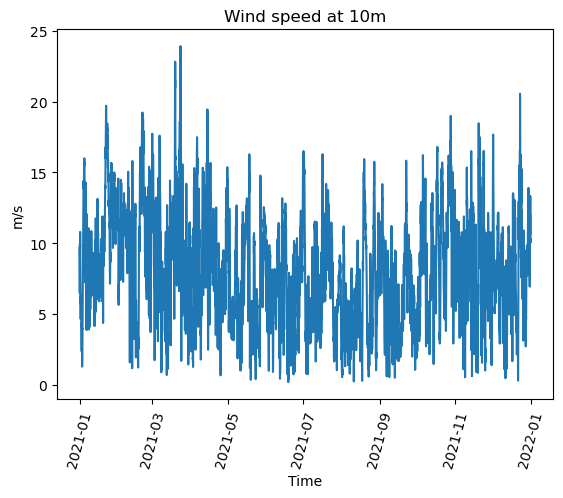

In [42]:
plt.plot(nice_time, ws)
plt.title("Wind speed at 10m")
plt.ylabel("m/s")
plt.xlabel("Time")

plt.tick_params(axis='x', labelcolor='black', labelrotation=75, labelsize=10)
plt.show()

# Histogram
This is an example on how to make a histogram from the wind speeds

Text(0.5, 1.0, 'Weibull distribution of wind speed at SN76956')

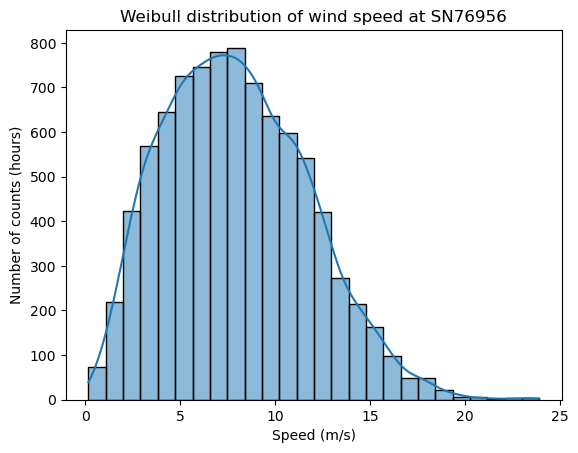

In [45]:
#install the seaborn package by removing the "#" and running the code below 
#!pip3 install seaborn

import seaborn as sns

sns.histplot(data = ncfile, x = ws, kde = True, bins = 26)
plt.xlabel("Speed (m/s)")
plt.ylabel("Number of counts (hours)")
plt.title(f"Weibull distribution of wind speed at {station_id}")


# Windrose
the following example show how to make a windrose at the chosen site and timespan. The windrose illustrates the distribution of wind speed and direction together. The direction in degrees is transformed into cardinal directions, 360 = N, 180 = S, 90 = E, 270 = W  

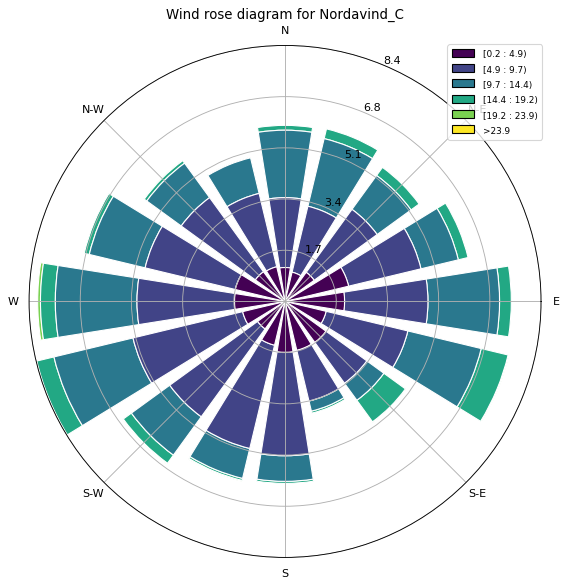

In [46]:
# run the code below if not already installed the windrose package 
#!pip3 install windrose

from windrose import WindroseAxes

speed = ncfile.variables["wind_speed"][:]
direction = ncfile.variables["wind_direction"][:] 

ax = WindroseAxes.from_ax()
ax.bar(direction,
       speed,
       normed=True, #get % of number of hours
       opening= 0.8, #width of bars
       edgecolor='white')
ax.set_legend(loc = "best")
plt.title(f"Wind rose diagram for {site_name}")
plt.show()


## Plot with two variables 

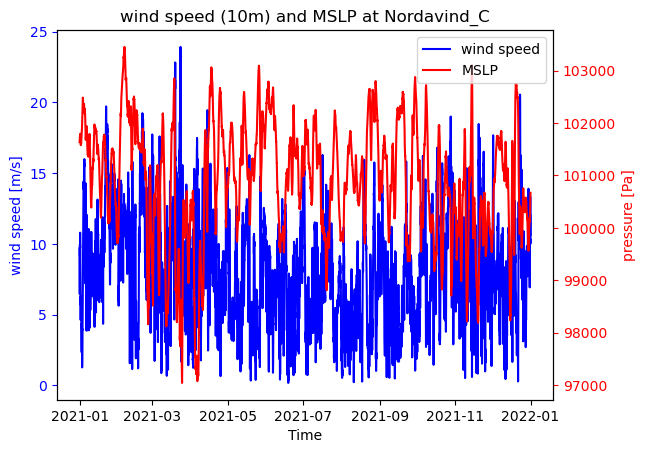

In [47]:

# plot med 2 x-akser med samme y-verider
fig, ax1 = plt.subplots()


ax1.plot(nice_time, ws, color="b", label="wind speed") # first plot

ax2 = ax1.twinx() # second plot with same x-value (time)
ax2.plot(nice_time, press, color="r", label="MSLP")


#label
ax1.set_ylabel("wind speed [m/s]", color="b")
ax2.set_ylabel("pressure [Pa]", color="r")

ax1.set_xlabel("Time")

# color the y-axes
ax1.tick_params(axis='y', colors="b")
ax2.tick_params(axis='y', colors="r")

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.tick_params(axis='x', labelcolor='black', labelrotation=75, labelsize=10)

plt.title(f"wind speed (10m) and MSLP at {site_name}")

plt.show()